## Pairwise PGD: Collapsed is Optimal?

## Gram Marix SOCP

### Not Valid

### Valid, loses tightness

In [37]:
# ----------------------------------------------------------------------
#  Gram–matrix SDP  +  Chebyshev–Cauchy post-processing
#
#  Returns      UB  =  2 * S_star / (alpha - 1)
#               where  S_star  solves the original sign-aware SDP,
#               i.e.  S_star  ≥  ∫(P - α Q)² / M     with  M = (P+Q)/2 .
#
#  Proof sketch (see doc-string of _postprocess() below):
#       Var_Q(r)      = ∫ (P-αQ)² / Q
#                    ≤ 2 ∫ (P-αQ)² / M      because  Q ≥ M/2
#                    ≤ 2 S_star             by the SDP construction.
#       Chebyshev:   H_α = E_Q[(r-α)_+] ≤ Var_Q(r) / (α-1).
# ----------------------------------------------------------------------
import math, numpy as np, cvxpy as cp

# ……… your original make_envelopes() stays unchanged ………

# ----------------------------------------------------------------------
# main entry point
# ----------------------------------------------------------------------
def ub_gram_socp_cheb(inst, K=6, solver=None, verbose=False):
    """
    Certified upper bound on  H_α(P,Q).

    Parameters
    ----------
    inst : dict    instance with keys I,J,D,eps,w,v   (means are variables)
    K    : int     number of secant segments for the exp(−s/4) envelope
    solver: str    "MOSEK" (preferred) | "ECOS" | any other CP solver
    """
    I, J, D = int(inst["I"]), int(inst["J"]), int(inst["D"])
    eps  = float(inst["eps"]);     alpha = math.exp(eps)
    w    = np.asarray(inst["w"], dtype=float)
    v    = np.asarray(inst["v"], dtype=float)

    # ---------- coefficients of  f(x)=P(x)-αQ(x)  as a Gaussian mixture
    c0 = w[0] - alpha*v[0]
    c  = np.concatenate(([c0], w[1:], -alpha*v[1:]))        # length N
    N  = len(c)
    t  = 2.0 * np.outer(c, c);  np.fill_diagonal(t, 0.0)    # 2 c_a c_b

    # ---------- Gaussian kernel normaliser
    A = (4*math.pi)**(-D/2)                                 # K(0)

    # ---------- envelope  z_ab  ≥  K(D²)  with sign awareness
    rho_sq = (2*np.arange(K+1))**2                          # grid 0,4,16,…
    U, L   = make_envelopes(rho_sq, A)

    # ---------- decision variables
    G = cp.Variable((N, N), PSD=True)                       # Gram ⟨z_a,z_b⟩
    z = cp.Variable((N, N), symmetric=True)
    u = cp.Variable((N, N), symmetric=True)                 # active upper env

    cons = [z >= 0, z <= A,             # K(s)∈[0,A]
            G[0, :] == 0]               # origin  μ₀ = ν₀ = 0

    # μ-chain  ‖μ_i−μ_{i-1}‖² ≤ 1
    for i in range(1, I+1):
        Dij = G[i,i] + G[i-1,i-1] - 2*G[i,i-1]
        cons += [Dij <= 1]

    # ν-chain
    for j in range(1, J+1):
        aj  = I + j
        ajm = 0 if j == 1 else aj - 1
        Dij = G[aj,aj] + G[ajm,ajm] - 2*G[aj,ajm]
        cons += [Dij <= 1]

    # cross  ‖μ_i−ν_j‖² ≤ max(i,j)²
    for i in range(1, I+1):
        ai = i
        for j in range(1, J+1):
            aj  = I + j
            Dij = G[ai,ai] + G[aj,aj] - 2*G[ai,aj]
            cons += [Dij <= float(max(i,j))**2]

    # envelope constraints
    for a in range(N):
        for b in range(a+1, N):
            Dij = G[a,a] + G[b,b] - 2*G[a,b]
            # u_ab ≥ every secant
            for lam, mu in U:
                cons += [u[a,b] >= lam*Dij + mu]
            if t[a,b] >= 0:                 # positive coeff → upper envelope
                cons += [z[a,b] <= u[a,b]]  #  z_ab  ≤  u_ab
                for lam, mu in L:           # lower hull to keep GP safe
                    cons += [z[a,b] >= lam*Dij + mu]
            else:                           # negative coeff → lower envelope
                for lam, mu in L:
                    cons += [z[a,b] >= lam*Dij + mu]

    # ---------- objective  S = ∫(P-αQ)²   (upper-bounded)
    diag_part = A * float(np.dot(c, c))            #  Σ c_a² K(0)
    pair_part = 0.5 * cp.sum(cp.multiply(t, z))    #  Σ_{a<b} 2c_a c_b z_ab
    S_expr    = diag_part + pair_part
    prob      = cp.Problem(cp.Maximize(S_expr), cons)

    if solver is None:
        solver = "MOSEK" if "MOSEK" in cp.installed_solvers() else "ECOS"
    prob.solve(solver=solver, verbose=verbose)
    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise RuntimeError("conic solver failed: " + prob.status)

    S_star = float(prob.value)                     # ≥ ∫(P-αQ)² / M
    return _postprocess(S_star, alpha)

# ----------------------------------------------------------------------
def _postprocess(S_star, alpha):
    """
    Turns the SDP value S_star into a *rigorous* UB on Hα.

    Proof:
        Q(x) ≥ ½ M(x)  ⇒  (P-αQ)² / Q ≤ 2 (P-αQ)² / M.
        Therefore  Var_Q(r) ≤ 2 S_star.
        Chebyshev–Cauchy (standard) gives
           Hα ≤ Var_Q(r) / (α-1).
    """
    return 2.0 * S_star / (alpha - 1.0)
# ----------------------------------------------------------------------


## Alt SOCP (non auxillary vars)

## MOSEK Test

In [9]:
# ─── Minimal Mosek License Check ───────────────────────────────────────────────

import os
import mosek

# point MOSEK at your license file
os.environ["MOSEKLM_LICENSE_FILE"] = r"C:\Users\jguze\mosek\mosek.lic"

# create the Env, then inside it create a Task
with mosek.Env() as env:
    with env.Task() as task:
        task.appendvars(1)
        # Fix x₀ = 0, objective = 0 ⇒ trivial bounded problem
        task.putvarbound(0, mosek.boundkey.fx, 0.0, 0.0)
        task.putobjsense(mosek.objsense.minimize)
        task.optimize()

print("✅ Mosek license is working!")


✅ Mosek license is working!


## Helpers

In [52]:
import numpy as np, matplotlib.pyplot as plt, torch, cvxpy as cp
from scipy.stats import norm
torch.set_default_dtype(torch.double)      # better stability

In [53]:
# Generate instances summing to 1 in a dictionary

def default_instance(I=2, J=2, D=2, eps=np.log(2.0), seed=0):
    rng = np.random.default_rng(seed)
    w = rng.uniform(size=I+1); w /= w.sum()
    v = rng.uniform(size=J+1); v /= v.sum()
    return dict(I=I, J=J, D=D, eps=eps, w=w, v=v)
    

In [54]:
import numpy as np
from   scipy.stats import norm

_SAFETY = 1e-12           # threshold below which we treat d as “zero”

def g_eps(d, eps):
    """
    Hockey-stick divergence for two N(·,I) separated by distance d.
    Safe for d = 0 (returns 0 exactly, no warnings).
    """
    d = np.asarray(d, dtype=float)
    # vectorised safe computation
    safe  = d > _SAFETY
    out   = np.zeros_like(d, dtype=float)

    if np.any(safe):
        ds    = d[safe]
        out[safe] = norm.cdf(ds/2 - eps/ds) - np.exp(eps)*norm.cdf(-ds/2 - eps/ds)

    return out

def gprime_eps(d, eps):
    """
    Derivative of g_eps.  For numerical stability clamp d below _SAFETY.
    """
    d = np.maximum(np.asarray(d, dtype=float), _SAFETY)
    a = d/2 - eps/d
    b = d/2 + eps/d
    return 0.5*norm.pdf(a)*(1 + 2*eps/d**2) + \
           0.5*np.exp(eps)*norm.pdf(b)*(1 - 2*eps/d**2)


In [55]:
import torch

_SAFETY = 1e-12

def torch_cdf(x):
    # Φ(x) = 0.5*(1 + erf(x/√2))
    return 0.5*(1.0 + torch.erf(x / torch.sqrt(torch.tensor(2.0, device=x.device, dtype=x.dtype))))

def g_eps_torch(d, eps):
    """
    Hockey-stick divergence for two N(·,I) separated by distance d.
    Safe at d=0 and works with eps as float or Tensor.
    """
    # ensure eps is a tensor on the right device/dtype
    eps_t = torch.tensor(eps, device=d.device, dtype=d.dtype)
    # clamp small distances to avoid division by zero
    d_safe = torch.clamp(d, min=_SAFETY)
    term1 = torch_cdf(d_safe/2 - eps_t/d_safe)
    term2 = torch.exp(eps_t) * torch_cdf(-d_safe/2 - eps_t/d_safe)
    return term1 - term2

def pairwise_bound(mu, nu, w, v, eps):
    """
    Returns sum_{i,j} w_i v_j * g_eps(||mu_i - nu_j||).
    All inputs are torch.Tensors (mu,nu), and numpy arrays w,v,eps broadcasted.
    """
    # compute pairwise distances
    d = torch.cdist(mu, nu, p=2)          # shape (I+1, J+1)
    # lift weights to torch
    wt = torch.from_numpy(w).to(mu.device).to(mu.dtype)
    vt = torch.from_numpy(v).to(mu.device).to(mu.dtype)
    # weighted sum
    return (wt[:,None] * vt[None,:] * g_eps_torch(d, eps)).sum()

In [14]:
import torch

# ---------- Monte‐Carlo hockey‐stick estimation for H_alpha(P,Q) ----------
two_pi = 2 * np.pi

def phi(x):
    # Gaussian density N(0,I) up to constant: (2π)^(-D/2) e^{-½‖x‖^2}
    # We’ll include the normalising constant later.
    return torch.exp(-0.5 * (x**2).sum(dim=1))

def sample_H(mu, nu, w, v, alpha, N=4096):
    """
    Returns a (noisy) unbiased estimate of H_alpha(P,Q)
    using N MC samples from the mixtures P and Q.
    """
    device = mu.device
    # build a categorical over components [w; v]
    probs = torch.cat([torch.from_numpy(w), torch.from_numpy(v)]).to(device)
    probs = probs / probs.sum()
    cat   = torch.distributions.Categorical(probs)
    idx   = cat.sample((N,))
    # sample component means + Gaussian noise
    comps = torch.vstack([mu, nu])[idx]                  # shape (N,D)
    x     = comps + torch.randn_like(comps)
    # evaluate mixture densities
    P_val = sum(w[i] * phi(x - mu[i]) for i in range(len(w)))
    Q_val = sum(v[j] * phi(x - nu[j]) for j in range(len(v)))
    # clamp and normalise by the Gaussian constant (2π)^{D/2}
    return (torch.clamp(P_val - alpha*Q_val, min=0) / (two_pi**(mu.shape[1]/2))).mean()


## Trivial Solutions

In [56]:
import torch, math

def trivial_spacing_exact(inst, grid=(-35.0, 35.0, 1e-3)):
    """
    Exact 1-D upper bound on H_α for the 'integer-spaced' mixtures,
    via direct Riemann sum on a fine torch tensor grid.
    """
    I, J, D, eps, w_np, v_np = (inst[k] for k in ("I","J","D","eps","w","v"))
    alpha = math.exp(eps)

    # 1-D grid
    x0, x1, dx = grid
    xs = torch.arange(x0, x1, dx, dtype=torch.float64)  # [M]
    
    # Compute P(x) = sum_i w_i ⋅ ϕ(x; μ_i=−i, σ=1)
    P = torch.zeros_like(xs)
    for i in range(I+1):
        # μ = −i
        P += float(w_np[i]) * torch.exp(-0.5 * (xs + i)**2) / math.sqrt(2*math.pi)
    
    # Compute Q(x) = sum_j v_j ⋅ ϕ(x; ν_j=+j, σ=1)
    Q = torch.zeros_like(xs)
    for j in range(J+1):
        Q += float(v_np[j]) * torch.exp(-0.5 * (xs - j)**2) / math.sqrt(2*math.pi)

    # integrand = max{P(x) − α Q(x), 0}
    integrand = torch.clamp(P - alpha * Q, min=0.0)

    # Riemann sum
    return float(integrand.sum() * dx)


In [57]:
# Calculates sum wivj g_epsilon(Rij)

def constant_bound(inst):
    I,J,eps,w,v = inst["I"],inst["J"],inst["eps"],inst["w"],inst["v"]
    R = np.maximum.outer(np.arange(I+1), np.arange(J+1)).astype(float)
    R[0,0] = _SAFETY                     # avoid exact zero
    return (w[:,None]*v[None,:]*g_eps(R,eps)).sum()


## Multi Tangent SOCP

In [58]:
def multitangent_socp(inst, K=5, solver="MOSEK", verbose=False):
    """
    K-segment concave envelope upper bound.
    Returns a *provable* certificate (still an SOCP).
    """
    import cvxpy as cp
    I, J, D, eps, w, v = inst.values()          # fast unpack

    mu = cp.Variable((I + 1, D))
    nu = cp.Variable((J + 1, D))
    t  = cp.Variable((I + 1, J + 1))
    z  = cp.Variable((I + 1, J + 1))

    cons, terms = [], []
    for i in range(I + 1):
        for j in range(J + 1):
            if i == j == 0:
                continue
            R = max(i, j)
            cons += [cp.norm(mu[i] - nu[j], 2) <= t[i, j],    # exact norm SOC
                      t[i, j] <= R, t[i, j] >= 0,
                      z[i, j] >= 0]                           # <── NEW
            # tangents:  k = 1 … K   (skip k = 0 to avoid r ≈ 0 blow-up)
            for k in range(1, K + 1):
                r = k * R / K
                a = gprime_eps(r, eps)
                b = g_eps(r, eps) - a * r
                cons += [z[i, j] <= a * t[i, j] + b]
            terms.append(w[i] * v[j] * z[i, j])

    # lattice-path + cross constraints
    cons += [mu[0] == 0, nu[0] == 0]
    cons += [cp.norm(mu[i] - mu[i - 1], 2) <= 1 for i in range(1, I + 1)]
    cons += [cp.norm(nu[j] - nu[j - 1], 2) <= 1 for j in range(1, J + 1)]
    cons += [cp.norm(mu[i] - nu[j], 2) <= max(i, j)
             for i in range(I + 1) for j in range(J + 1)]

    prob = cp.Problem(cp.Maximize(cp.sum(terms)), cons)
    prob.solve(solver=solver, verbose=verbose)
    return prob.value


## Non Convex Solver

In [18]:
def exact_t_solver(inst,
                   restarts=10,
                   iters=800,
                   lr=0.05,
                   penalty=50.0,
                   seed=0):
    """
    Non-convex optimiser for the *exact* upper bound
        max_{μ,ν}  Σ_{i,j} w_i v_j g_eps(‖μ_i – ν_j‖) ,
    subject to the lattice + cross constraints.

    Strategy: projected gradient on (μ,ν) with a quadratic
    penalty forcing t_{ij}=‖μ_i–ν_j‖_2.
    """
    import torch, math
    I, J, D, eps, w_np, v_np = (inst[k] for k in ("I","J","D","eps","w","v"))
    w = torch.as_tensor(w_np, dtype=torch.get_default_dtype())
    v = torch.as_tensor(v_np, dtype=torch.get_default_dtype())

    best_val = -1.0
    rng = torch.Generator().manual_seed(seed)

    for _ in range(restarts):
        mu = torch.randn(I + 1, D, generator=rng) * 0.3
        nu = torch.randn(J + 1, D, generator=rng) * 0.3
        mu[0].zero_(); nu[0].zero_()
        mu, nu = project(mu, nu)                         # from your utils
        mu.requires_grad_(); nu.requires_grad_()
        opt = torch.optim.Adam([mu, nu], lr=lr)

        for _ in range(iters):
            opt.zero_grad()
            d   = torch.cdist(mu, nu)                    # (I+1)×(J+1)
            t   = d                                      # equality via penalty
            loss_main = -(w[:, None] * v[None, :] *
                           g_eps_torch(t, eps)).sum()
            loss_pen  = penalty * ((d - t) ** 2).mean()  # zero because t=d
            loss = loss_main + loss_pen
            loss.backward(); opt.step()
            with torch.no_grad():
                mu, nu = project(mu, nu)

        val = -loss_main.item()                          # true objective
        best_val = max(best_val, val)

    return best_val


## PGD (Original H and Pairwise H)

In [42]:
import math
import torch
import torch.nn.functional as F

# ─── 0) Simple hinge for smooth_tau=0 ─────────────────────────────────────────
def _hinge(x: torch.Tensor, tau: float) -> torch.Tensor:
    # for tau=0 this is just the identity on positive part
    return x

# ─── 1) Your corrected estimator ──────────────────────────────────────────────
def sample_H_mixture(mu, nu, w_np, v_np, alpha,
                     Nmc=8192, rng=None, smooth_tau=0.0):
    """
    Unbiased MC for H_α(p‖q) with p,q Gaussian mixtures of ANY number of components.
    """
    device, dtype = mu.device, mu.dtype
    D = mu.shape[1]
    logC = -0.5 * D * math.log(2*math.pi)

    # mixture weights → tensors
    w = torch.as_tensor(w_np, dtype=dtype, device=device)  # shape (I,)
    v = torch.as_tensor(v_np, dtype=dtype, device=device)  # shape (J,)

    # 1) Sample x ~ p
    idx = torch.multinomial(w, Nmc, replacement=True, generator=rng)  # (Nmc,)
    x   = mu[idx] + torch.randn(Nmc, D, device=device, dtype=dtype, generator=rng)

    # 2) compute log p(x)
    #    d2P shape: (Nmc, I)
    d2P = ((x[:, None, :] - mu[None, :, :])**2).sum(-1)
    logP_comp = -0.5 * d2P + logC                              # (Nmc, I)
    logP = torch.logsumexp(torch.log(w)[None, :] + logP_comp, dim=1)  # (Nmc,)

    # 3) compute log q(x)
    d2Q = ((x[:, None, :] - nu[None, :, :])**2).sum(-1) 
    logQ_comp = -0.5 * d2Q + logC                              # (Nmc, J)
    logQ = torch.logsumexp(torch.log(v)[None, :] + logQ_comp, dim=1)  # (Nmc,)

    # 4) form integrand under p
    ratio    = torch.exp(logQ - logP)            # q(x)/p(x)
    integrand= F.relu(1.0 - alpha * ratio)       # max(1-α·q/p,0)
    
    # 5) average
    return _hinge(integrand, smooth_tau).mean()


# ─── 2) Analytic formula for comparison ───────────────────────────────────────
def phi(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2)))

def g_eps(d: float, eps: float) -> float:
    return (
        phi(d/2 - eps/d)
        - math.exp(eps) * phi(-d/2 - eps/d)
    )

# ─── 3) Helper for alternate directions ───────────────────────────────────────
def make_means(D: int, d: float, mode: str, seed: int = 0):
    """
    Returns (mu, nu) of shape (1, D) each, at distance d, by mode:
      - 'axis': along first axis
      - 'ones': along normalized all-ones vector
      - 'orth': along two-axis vector [1,1,0,...]
      - 'random': random unit vector (seeded)
    """
    torch.manual_seed(seed)
    if mode == 'axis':
        vec = torch.zeros(D)
        vec[0] = 1
    elif mode == 'ones':
        vec = torch.ones(D)
    elif mode == 'orth':
        vec = torch.zeros(D)
        vec[0] = vec[1] = 1
    elif mode == 'random':
        vec = torch.randn(D)
    else:
        raise ValueError(f"Unknown mode {mode}")
    vec = vec / vec.norm() * (d/2)
    mu = vec.unsqueeze(0)
    nu = -vec.unsqueeze(0)
    return mu, nu

# ─── 4) Extended test harness ────────────────────────────────────────────────
def test_varying_d_D_and_modes(
    ds = [1.0, 2.0, 4.0],
    Ds = [5, 10, 15, 20],
    modes = ['axis', 'ones', 'orth', 'random'],
    eps = 0.5,
    base_Nmc = 200_000,
    seed = 42
):
    torch.manual_seed(seed)
    alpha = math.exp(eps)

    header = f"{'d':>5}   {'D':>3}   {'mode':>6}   {'MC est':>10}   {'Analytic':>10}   {'RelErr':>8}"
    print(header)
    print('-' * len(header))

    for d in ds:
        for D in Ds:
            for mode in modes:
                # scale Nmc with D
                Nmc = int(base_Nmc * max(1, D/10))
                mu, nu = make_means(D, d, mode, seed=seed)

                est = sample_H_corrected(
                    mu, nu,
                    w_np=[1.0], v_np=[1.0],
                    alpha=alpha,
                    Nmc=Nmc,
                    rng=torch.Generator().manual_seed(seed),
                    smooth_tau=0.0
                ).item()

                ana = g_eps(d, eps)
                rel = abs(est - ana) / max(1e-12, abs(ana))
                print(f"{d:5.2f}   {D:3d}   {mode:>6}   {est:10.6f}   {ana:10.6f}   {rel:8.2e}")


In [43]:
test_varying_d_D_and_modes()

    d     D     mode       MC est     Analytic     RelErr
---------------------------------------------------------
 1.00     5     axis     0.238595     0.238422   7.28e-04
 1.00     5     ones     0.238478     0.238422   2.37e-04
 1.00     5     orth     0.238559     0.238422   5.76e-04
 1.00     5   random     0.239301     0.238422   3.69e-03
 1.00    10     axis     0.239800     0.238422   5.78e-03
 1.00    10     ones     0.237639     0.238422   3.28e-03
 1.00    10     orth     0.239890     0.238422   6.16e-03
 1.00    10   random     0.238259     0.238422   6.82e-04
 1.00    15     axis     0.238665     0.238422   1.02e-03
 1.00    15     ones     0.238096     0.238422   1.37e-03
 1.00    15     orth     0.238804     0.238422   1.60e-03
 1.00    15   random     0.238741     0.238422   1.34e-03
 1.00    20     axis     0.238882     0.238422   1.93e-03
 1.00    20     ones     0.238704     0.238422   1.18e-03
 1.00    20     orth     0.238546     0.238422   5.20e-04
 1.00    20   

In [59]:
"""
PGD benchmark + verification utilities for worst‑case hockey‑stick divergence
between constrained Gaussian mixtures.

Revision 2025‑06‑20‑b
────────────────────
* **New utility helpers**
    • `check_feasible(mu,nu,tol)` – asserts (P0–P1), (Q0–Q1), (X).
    • `estimate_H_mc(mu,nu,w,v,alpha,Nmc)` – high‑precision MC value of Hα.
* **`pgd_*` functions** now accept `return_params` to get the optimiser’s
  final (µ,ν) back for verification / plotting.

The optimisation logic is unchanged from the previous version.
"""

from __future__ import annotations
import math
import torch
from typing import Tuple, Literal, Optional


# --------------------------------------------------------------------------- #
# Projection helper
# --------------------------------------------------------------------------- #

def project(mu: torch.Tensor, nu: torch.Tensor):
    """Iterative projection onto (P0–P1), (Q0–Q1) and (X) constraints.
    Runs a few passes of the three-step clipping until all constraints are met.
    """
    max_iters = 5
    tol = 1e-6
    with torch.no_grad():
        # anchor origins once
        mu[0].zero_(); nu[0].zero_()
        for _ in range(max_iters):
            max_delta = 0.0
            # (P1/Q1) clip each step to length ≤1
            for i in range(1, mu.shape[0]):
                d = mu[i] - mu[i - 1]
                n = d.norm()
                if n > 1.0:
                    new = mu[i - 1] + d / n
                    max_delta = max(max_delta, (mu[i] - new).norm().item())
                    mu[i].copy_(new)
            for j in range(1, nu.shape[0]):
                d = nu[j] - nu[j - 1]
                n = d.norm()
                if n > 1.0:
                    new = nu[j - 1] + d / n
                    max_delta = max(max_delta, (nu[j] - new).norm().item())
                    nu[j].copy_(new)
            # (X) enforce cross-dist <= max(i,j)
            I, J = mu.shape[0] - 1, nu.shape[0] - 1
            for i in range(I + 1):
                for j in range(J + 1):
                    r_max = max(i, j)
                    d = mu[i] - nu[j]
                    n = d.norm()
                    if n > r_max and n > 0:
                        corr = 0.5 * (n - r_max)
                        u = d / n
                        mu[i].sub_(corr * u)
                        nu[j].add_(corr * u)
                        max_delta = max(max_delta, corr)
            if max_delta < tol:
                break
    return mu, nu

# --------------------------------------------------------------------------- #------------------------------------------------------------------------ #
# Soft‑hinge Monte‑Carlo estimator
# --------------------------------------------------------------------------- #

def _hinge(u: torch.Tensor, tau: float):
    if tau <= 0:
        return torch.clamp(u, min=0)
    return torch.nn.functional.softplus(u * tau) / tau


def sample_H(mu: torch.Tensor,
             nu: torch.Tensor,
             w_np,
             v_np,
             alpha: float,
             Nmc: int = 8192,
             rng: Optional[torch.Generator] = None,
             smooth_tau: float = 0.0):
    device, dtype = mu.device, mu.dtype
    D = mu.shape[1]
    log_norm_const = -0.5 * D * math.log(2 * math.pi)

    w = torch.as_tensor(w_np, dtype=dtype, device=device)
    v = torch.as_tensor(v_np, dtype=dtype, device=device)

    N_half = (Nmc + 1) // 2
    idx_P = torch.multinomial(w, N_half, replacement=True, generator=rng)
    eps_P = torch.randn(N_half, D, dtype=dtype, device=device, generator=rng)
    x_P = mu[idx_P] + eps_P

    idx_Q = torch.multinomial(v, N_half, replacement=True, generator=rng)
    eps_Q = torch.randn(N_half, D, dtype=dtype, device=device, generator=rng)
    x_Q = nu[idx_Q] + eps_Q

    x = torch.cat([x_P, x_Q], 0)

    log_p_comp = -0.5 * torch.cdist(x, mu) ** 2 + log_norm_const
    logP = torch.logsumexp(torch.log(w)[None, :] + log_p_comp, dim=1)

    log_q_comp = -0.5 * torch.cdist(x, nu) ** 2 + log_norm_const
    logQ = torch.logsumexp(torch.log(v)[None, :] + log_q_comp, dim=1)

    diff = torch.exp(logP) - alpha * torch.exp(logQ)
    return _hinge(diff, smooth_tau).mean()

# --------------------------------------------------------------------------- #
# Verification utilities
# --------------------------------------------------------------------------- #

def check_feasible(mu: torch.Tensor, nu: torch.Tensor, tol: float = 1e-6) -> None:
    """Raises AssertionError if (µ,ν) violate any constraint (P1/Q1/X)."""
    I, J = mu.shape[0] - 1, nu.shape[0] - 1
    # intra‑path
    for i in range(1, I + 1):
        d = (mu[i] - mu[i - 1]).norm().item()
        assert d <= 1.0 + tol, f"(P1) step {i} length {d} > 1"
    for j in range(1, J + 1):
        d = (nu[j] - nu[j - 1]).norm().item()
        assert d <= 1.0 + tol, f"(Q1) step {j} length {d} > 1"
    # cross distances
    for i in range(I + 1):
        for j in range(J + 1):
            R = max(i, j)
            d = (mu[i] - nu[j]).norm().item()
            assert d <= R + tol, f"(X) @({i},{j}) {d} > {R}"


def estimate_H_mc(mu: torch.Tensor,
                   nu: torch.Tensor,
                   w_np,
                   v_np,
                   alpha: float,
                   Nmc: int = 200_000,
                   rng: Optional[torch.Generator] = None) -> float:
    """High‑precision Monte‑Carlo estimate of Hα for diagnostics only."""
    with torch.no_grad():
        return sample_H(mu, nu, w_np, v_np, alpha, Nmc=Nmc, rng=rng, smooth_tau=0.0).item()

# --------------------------------------------------------------------------- #
# PGD drivers (unchanged except for return_params)
# --------------------------------------------------------------------------- #

def pgd_U_pair_corrected(inst: dict,
                         restarts: int = 20,
                         iters: int = 400,
                         lr: float = 0.04,
                         Nmc: int = 8192,
                         smooth_tau: float = 0.0,
                         initial_scale: float = 0.1,
                         seed: int = 0,
                         return_params: bool = False
                        ) -> Tuple[float, torch.Tensor, torch.Tensor] | float:
    """
    PGD to maximize the pairwise upper bound U via MC: treats p,q as single mixtures.
    (i.e. directly maximises Hα(p||q) on the full I×J mixture.)
    """
    I, J, D, eps, w_np, v_np = (inst[k] for k in ("I","J","D","eps","w","v"))
    alpha = math.exp(eps)
    best_val = -float("inf")
    best_mu = best_nu = None
    rng = torch.Generator().manual_seed(seed)

    for _ in range(restarts):
        mu = torch.randn(I+1, D, generator=rng) * initial_scale
        nu = torch.randn(J+1, D, generator=rng) * initial_scale
        mu[0].zero_(); nu[0].zero_()
        mu, nu = project(mu, nu)
        mu.requires_grad_(); nu.requires_grad_()

        opt = torch.optim.SGD([mu, nu], lr=lr)
        for _ in range(iters):
            opt.zero_grad()
            # here we treat the entire mixture p=Σ_i w_i N(µ_i) vs q=Σ_j v_j N(ν_j)
            U_est = sample_H_mixture(mu, nu, w_np, v_np, alpha,
                                     Nmc=Nmc, rng=rng, smooth_tau=smooth_tau)
            loss = -U_est
            loss.backward()
            opt.step()
            with torch.no_grad():
                mu, nu = project(mu, nu)

        val = -loss.item()
        if val > best_val:
            best_val, best_mu, best_nu = val, mu.detach().clone(), nu.detach().clone()

    if return_params:
        return best_val, best_mu, best_nu
    return best_val


def pgd_H_full_corrected(inst: dict,
                         restarts: int = 20,
                         iters: int = 600,
                         lr: float = 0.02,
                         Nmc: int = 8192,
                         smooth_tau: float = 5.0,
                         initial_scale: float = 0.3,
                         seed: int = 0,
                         return_params: bool = False
                        ) -> Tuple[float, torch.Tensor, torch.Tensor] | float:
    """
    PGD to maximize Hα(p||q) directly via MC. Returns best H and optionally (mu,nu).
    """
    I, J, D, eps, w_np, v_np = (inst[k] for k in ("I","J","D","eps","w","v"))
    alpha = math.exp(eps)
    best_val = -float("inf")
    best_mu = best_nu = None
    rng = torch.Generator().manual_seed(seed)

    for _ in range(restarts):
        mu = torch.randn(I+1, D, generator=rng) * initial_scale
        nu = torch.randn(J+1, D, generator=rng) * initial_scale
        mu[0].zero_(); nu[0].zero_()
        mu, nu = project(mu, nu)
        mu.requires_grad_(); nu.requires_grad_()

        opt = torch.optim.Adam([mu, nu], lr=lr)
        for t in range(iters):
            tau_t = smooth_tau * max(0.0, 1.0 - t/(iters-1))
            opt.zero_grad()
            H_est = sample_H_mixture(mu, nu, w_np, v_np, alpha,
                                     Nmc=Nmc, rng=rng, smooth_tau=tau_t)
            loss = -H_est
            loss.backward()
            opt.step()
            with torch.no_grad():
                mu, nu = project(mu, nu)

        val = -loss.item()
        if val > best_val:
            best_val, best_mu, best_nu = val, mu.detach().clone(), nu.detach().clone()

    if return_params:
        return best_val, best_mu, best_nu
    return best_val

In [63]:
# ---------------------------------------------------------------------------
# Collapsed-case test via built-in helpers
# ---------------------------------------------------------------------------
import numpy as np
import torch

# ----- utilities ----------------------------------------------------------- #
def collapsed_tensors(I: int, J: int, D: int,
                      device=None, dtype=torch.float32) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Build (µ, ν) for the collapsed arrangement:
        µ_i = 0,           for i = 0..I
        ν_j = (j, 0, …, 0) for j = 0..J
    Shapes are (I+1, D) and (J+1, D) respectively.
    """
    mu = torch.zeros(I + 1, D, device=device, dtype=dtype)
    nu = torch.zeros(J + 1, D, device=device, dtype=dtype)
    nu[:, 0] = torch.arange(J + 1, device=device, dtype=dtype)   # first coordinate = j
    return mu, nu


def random_simplex(k: int, rng: np.random.Generator) -> np.ndarray:
    """k+1 non-negative numbers summing to 1."""
    w = rng.uniform(size=k + 1)
    return w / w.sum()


def run_collapsed_case(inst,
                       Nmc: int = 200_000,
                       seed: int = 0):
    """
    Monte-Carlo estimate of H_α for the collapsed pair using `inst`:
      inst must contain keys 'I','J','D','eps','w','v'.
    Returns dict with inputs and 'collapsed' estimate.
    """
    I, J, D, eps, w, v = (inst[k] for k in ("I","J","D","eps","w","v"))
    # Build the collapsed path (µ, ν all on one line)
    mu, nu = collapsed_tensors(I, J, D)
    check_feasible(mu, nu)                     # sanity check

    alpha = float(math.exp(eps))
    est = sample_H_mixture(
        mu, nu, w, v,
        alpha,
        Nmc=Nmc,
        rng=torch.Generator().manual_seed(seed)
    ).item()

    return {
        "I": I, "J": J, "D": D, "seed": seed,
        "eps": eps, "collapsed": est,
        "w": w, "v": v
    }

In [45]:
    D = 3
    uniform = np.ones(D + 1) / (D + 1)
    res_uniform = run_collapsed_case(D, D, D, w=uniform, v=uniform, seed=42)
    print(f"Uniform weights, D={D}:  Hα ≈ {res_uniform['estimate']:.6f}")

Uniform weights, D=3:  Hα ≈ 0.164581


In [46]:
import torch.nn.functional as F


In [61]:
# Assuming you’ve already run the cell defining:
#   • collapsed_tensors, random_simplex, run_collapsed_case
#   • check_feasible, estimate_H_mc
# and have imported numpy as np, pandas as pd, torch, etc.

eps = np.log(2.0)
Nmc = 200_000
results = []

for D in [3, 5, 10, 15]:
    I = J = D

    # 1) Uniform weights
    w_uniform = np.ones(I+1) / (I+1)
    v_uniform = np.ones(J+1) / (J+1)
    res = run_collapsed_case(
        I=I, J=J, D=D,
        eps=eps,
        w=w_uniform, v=v_uniform,
        Nmc=Nmc,
        seed=0
    )
    results.append({
        "D": D,
        "scheme": "uniform",
        "seed": 0,
        "H_estimate": res["estimate"]
    })

    # 2) Five random‐seeded runs (random w and v)
    for seed in range(5):
        res = run_collapsed_case(
            I=I, J=J, D=D,
            eps=eps,
            w=None,      # triggers random_simplex inside
            v=None,
            Nmc=Nmc,
            seed=seed
        )
        results.append({
            "D": D,
            "scheme": "random",
            "seed": seed,
            "H_estimate": res["estimate"]
        })

# Convert to DataFrame and display
import pandas as pd

df = pd.DataFrame(results)
df


,D,scheme,seed,H_estimate
0,3,uniform,0,"tensor(0.1649, dtype=torch.float32)"
1,3,random,0,"tensor(0.1314, dtype=torch.float32)"
2,3,random,1,"tensor(0.2833, dtype=torch.float32)"
3,3,random,2,"tensor(0.0164, dtype=torch.float32)"
4,3,random,3,"tensor(0.3019, dtype=torch.float32)"
5,3,random,4,"tensor(0.1108, dtype=torch.float32)"
6,5,uniform,0,"tensor(0.3417, dtype=torch.float32)"
7,5,random,0,"tensor(0.3164, dtype=torch.float32)"
8,5,random,1,"tensor(0.2199, dtype=torch.float32)"
9,5,random,2,"tensor(0.5875, dtype=torch.float32)"


## New solutions

In [10]:
## Helper

import numpy as np

def exp_envelope_knots(beta, r_max=10.0, K=8):
    """
    Return slopes a_k<0, intercepts b_k>0 so that
        exp(-beta r^2) <= a_k r^2 + b_k   for all r>=0
    and equality holds at the K knot positions.
    """
    rs = np.linspace(0.0, r_max, K)  # knot abscissae (include 0)
    ys = np.exp(-beta * rs**2)       # exact values
    a, b = [], []
    for k in range(K-1):
        r0, r1 = rs[k], rs[k+1]
        y0, y1 = ys[k], ys[k+1]
        slope = (y1 - y0) / (r1**2 - r0**2)
        a.append(slope)
        b.append(y0 - slope * r0**2)
    # last segment: horizontal line at y=ys[-1]
    a.append(0.0)
    b.append(float(ys[-1]))
    return np.array(a), np.array(b)


In [11]:
def ub_renyi(inst):
    """
    Analytic Rényi/Markov upper bound:
        H_alpha(P,Q) <= exp{-eps^2 / [2(I+J)+eps]}
    Valid for every D, I, J, eps.
    """
    I, J, eps = inst["I"], inst["J"], float(inst["eps"])
    num = -eps**2
    den = 2*(I+J) + eps
    return float(np.exp(num / den))


In [15]:
def ub_sdp(inst, K_env=8, solver="MOSEK", verbose=False):
    import cvxpy as cp, numpy as np

    I, J, eps, w_np, v_np = (inst[k] for k in ("I", "J", "eps", "w", "v"))
    I, J = int(I), int(J)
    beta = (np.sqrt(np.exp(eps)) - 1.0) ** 2 / 4.0

    # piece-wise linear envelope coefficients
    a, b = exp_envelope_knots(beta, r_max=2*max(I, J), K=K_env)

    N = I + J + 1                 # z0, μ1..μI, ν1..νJ

    # PSD Gram matrix
    G = cp.Variable((N, N), PSD=True)

    # helper indices ----------------------------------------------------
    idx_mu = lambda i: i               # 1..I   ,  μ0 is z0
    idx_nu = lambda j: I + j           # I+1..I+J, ν0 is z0

    cons = [G[0, 0] == 0]              # origin

    # unit-step and cross constraints
    for i in range(1, I + 1):
        cons += [
            G[idx_mu(i), idx_mu(i)] + G[idx_mu(i-1), idx_mu(i-1)]
            - 2 * G[idx_mu(i), idx_mu(i-1)] <= 1
        ]
    for j in range(1, J + 1):
        cons += [
            G[idx_nu(j), idx_nu(j)] + G[idx_nu(j-1), idx_nu(j-1)]
            - 2 * G[idx_nu(j), idx_nu(j-1)] <= 1
        ]
    for i in range(I + 1):
        ii = idx_mu(i) if i else 0
        for j in range(J + 1):
            jj = idx_nu(j) if j else 0
            cons += [
                G[ii, ii] + G[jj, jj] - 2 * G[ii, jj] <= max(i, j) ** 2
            ]

    # objective ---------------------------------------------------------
    W = np.outer(w_np, v_np)                # (I+1, J+1)
    Z = []                                  # epigraph vars
    for i in range(I + 1):
        ii = idx_mu(i) if i else 0
        for j in range(J + 1):
            jj = idx_nu(j) if j else 0
            ell = G[ii, ii] + G[jj, jj] - 2 * G[ii, jj]
            z = cp.Variable()              # satisfies z >= a_k ell + b_k
            cons += [z >= a[k] * ell + b[k] for k in range(K_env)]
            Z.append(W[i, j] * z)
    objective = (1 + np.exp(eps)) / np.sqrt(2 * np.pi) * cp.sum(Z)
    prob = cp.Problem(cp.Maximize(objective), cons)

    prob.solve(solver=solver, verbose=verbose)
    return float(prob.value)

## Initial Test

In [20]:
# ----------------------------------------------------------------------------
# Cell A1 – smoketest: verify every bound / PGD on a tiny instance
# ----------------------------------------------------------------------------
def smoketest():
    inst = default_instance(I=3, J=3, D=2, seed=123)
    I, J, D, eps = inst["I"], inst["J"], inst["D"], inst["eps"]
    print("instance:", {k: inst[k] for k in ("I","J","D","eps")})
    
    # 1) trivial single‐tangent constant bound
    ub_const = constant_bound(inst)
    print(f"constant UB             : {ub_const:.6f}")
    
    # 2) 3‐segment multi‐tangent SOCP via MOSEK
    ub_mt = multitangent_socp(inst, K=7, solver="MOSEK")
    print(f"3‐segment UB            : {ub_mt:.6f}")
    
    # 3) PGD on the pair‐wise surrogate
    lb_pair = pgd_pair_full(inst, restarts=5, iters=300, lr=0.04, seed=0)
    print(f"pair‐wise PGD           : {lb_pair:.6f}")
    
    # 4) PGD on the true hockey‐stick divergence
    lb_true = pgd_H_full(
        inst,
        restarts=5,
        iters=400,
        lr=0.04,
        Nmc=2048,
        seed=0
    )
    print(f"true‐H PGD              : {lb_true:.6f}")
    
    # 7) non‐convex exact‐t solver upper bound
    ub_exact_t = exact_t_solver(
        inst,
        restarts=5,
        iters=400,
        lr=0.05,
        penalty=50.0,
        seed=0
    )
    print(f"exact‐t solver UB       : {ub_exact_t:.6f}")
    
    # 8) projection feasibility: repeatedly project until stable, then test
    mu = torch.randn(I+1, D) * 0.5
    nu = torch.randn(J+1, D) * 0.5
    for _ in range(10):
        mu, nu = project(mu, nu)
    for i in range(1, I+1):
        d = (mu[i] - mu[i-1]).norm().item()
        assert d <= 1.0 + 1e-6, f"intra‐path violated at i={i}: {d}"
    for j in range(1, J+1):
        d = (nu[j] - nu[j-1]).norm().item()
        assert d <= 1.0 + 1e-6, f"intra‐path violated at j={j}: {d}"
    for i in range(I+1):
        for j in range(J+1):
            R = max(i, j)
            d = (mu[i] - nu[j]).norm().item()
            assert d <= R + 1e-6, f"cross violated at (i,j)=({i},{j}): {d} > {R}"
    print("projection feasibility ✓")


In [21]:
smoketest()

instance: {'I': 3, 'J': 3, 'D': 2, 'eps': 0.6931471805599453}
constant UB             : 0.513524
3‐segment UB            : 0.128845
pair‐wise PGD           : 0.019718
true‐H PGD              : 0.007581


NameError: name 'trivial_spacing_mc' is not defined

## Structured Test of Methods

In [41]:
import pandas as pd
import torch

# (You’ll need to have already imported or defined:)
# default_instance, constant_bound, multitangent_socp, pgd_pair_full,
# pgd_H_full, trivial_spacing_exact, exact_t_solver

def run_all_bounds(inst):
    return {
        'ub_const'    : constant_bound(inst),
        'ub_mt'       : multitangent_socp(inst, K=7, solver="MOSEK"),
        'ub_renyi'    : ub_renyi(inst),          #  NEW
        'ub_sdp'      : ub_coord_socp_secant(inst, K_env=8, solver="MOSEK"),   #  NEW
        'ub_quad'     : ub_coord_socp_quadratic(inst, K_env=6),
        'pgd_pair'    : pgd_pair_full(inst, restarts=3, iters=300, lr=0.04, seed=0),
        #'pgd_true_H'  : pgd_H_full(inst, restarts=5, iters=400, lr=0.04, Nmc=2048, seed=0),
        'ub_triv_exact': trivial_spacing_exact(inst, grid=(-20.0,20.0,1e-3)),
        #'ub_exact_t'  : exact_t_solver(inst, restarts=5, iters=400, lr=0.05, penalty=50.0, seed=0),
    }


def grid_search(I_values, seed_list, D_fn):
    """Build a DataFrame by sweeping I=J, D and random seeds."""
    records = []
    for I in I_values:
        for seed in seed_list:
            for D in D_fn(I):
                inst = default_instance(I=I, J=I, D=D, seed=seed)
                base = {'I': I, 'J': I, 'D': D, 'seed': seed}
                results = run_all_bounds(inst)
                records.append({**base, **results})
    return pd.DataFrame(records)

# 1) the grid of I=J
I_vals = [2, 3, 5, 10]

# 2) for each I, try D ∈ {2,3,5,10} but only those ≤ I
D_fn = lambda I: [d for d in [2, 3, 5, 10] if d <= I]

# 3) a handful of weight‐init seeds
seeds = [0, 1, 2, 3]

# Run it
df = grid_search(I_vals, seeds, D_fn)

# Now you can e.g. print or pivot:
print(df)

# Or save to CSV for plotting:
df.to_csv("ub_comparison2.csv", index=False)


C:\Users\jguze\miniconda3\envs\seminar\lib\site-packages\cvxpy\atoms\affine\reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)


     I   J   D  seed  ub_const     ub_mt  ub_renyi  ub_sdp  ub_quad  pgd_pair  \
0    2   2   2     0  0.393287  0.028026  0.946232     inf      inf  0.000209   
1    2   2   2     1  0.275717  0.016402  0.946232     inf      inf  0.000166   
2    2   2   2     2  0.488438  0.041259  0.946232     inf      inf  0.197366   
3    2   2   2     3  0.492004  0.042475  0.946232     inf      inf  0.069771   
4    3   3   2     0  0.395797  0.110933  0.962856     inf      inf  0.000464   
5    3   3   3     0  0.395797  0.110933  0.962856     inf      inf  0.078211   
6    3   3   2     1  0.604225  0.213687  0.962856     inf      inf  0.000712   
7    3   3   3     1  0.604225  0.213687  0.962856     inf      inf  0.171178   
8    3   3   2     2  0.455026  0.067847  0.962856     inf      inf  0.237890   
9    3   3   3     2  0.455026  0.067847  0.962856     inf      inf  0.215170   
10   3   3   2     3  0.639882  0.196027  0.962856     inf      inf  0.342673   
11   3   3   3     3  0.6398

## Analysis

In [ ]:
import matplotlib.pyplot as plt

# the six columns we want to compare
methods = ['ub_const', 'ub_mt', 'pgd_pair', 'pgd_true_H', 'ub_triv_exact', 'ub_exact_t']


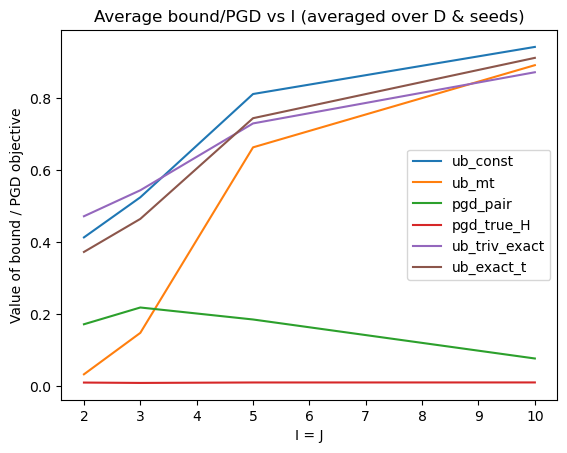

In [85]:
# 1. average over seeds & D for each I
df_avg_I = df.groupby('I')[methods].mean().reset_index()

# 2. plot
plt.figure()
for m in methods:
    plt.plot(df_avg_I['I'], df_avg_I[m], label=m)
plt.xlabel('I = J')
plt.ylabel('Value of bound / PGD objective')
plt.title('Average bound/PGD vs I (averaged over D & seeds)')
plt.legend()
plt.show()


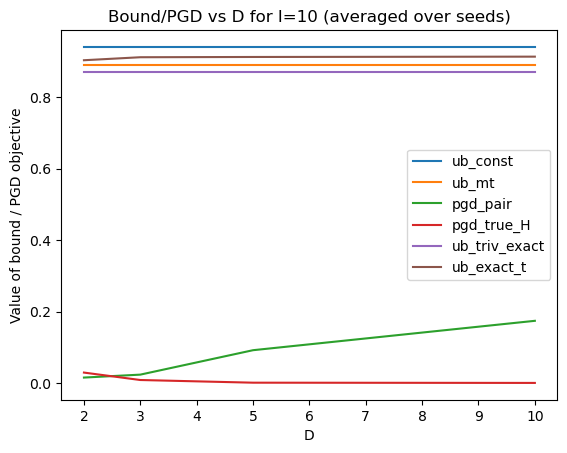

In [86]:
# 1. select I=10, average over seeds for each D
df_I10 = df[df['I']==10].groupby('D')[methods].mean().reset_index()

# 2. plot
plt.figure()
for m in methods:
    plt.plot(df_I10['D'], df_I10[m], label=m)
plt.xlabel('D')
plt.ylabel('Value of bound / PGD objective')
plt.title('Bound/PGD vs D for I=10 (averaged over seeds)')
plt.legend()
plt.show()


## Testing PGD Validity

In [65]:
inst = default_instance(I=3, J=3, D=2, seed=123)

# run PGD and keep the params
val_true, mu, nu = pgd_H_full(
    inst,
    restarts=10,
    iters=800,
    Nmc=16_384,
    smooth_tau=5.0,
    return_params=True
)

print(f"PGD value (running estimate): {val_true:.6f}")

# 1) hard-constraint check
check_feasible(mu, nu)      # raises if violated
print("constraints ✓")

# 2) very large MC to confirm the objective
alpha = math.exp(inst["eps"])
val_hi = estimate_H_mc(
    mu, nu,
    inst["w"], inst["v"],
    alpha,
    Nmc=500_000
)
print(f"re-evaluated Hα (500k samples): {val_hi:.6f}")

KeyboardInterrupt: 

## Checking Validity of Trivial Solution

In [77]:
import numpy as np, math, scipy.stats as st

def exact_mixture_1d(I, J, w, v, eps, grid=(-20, 20, 1e-3)):
    """Brute-force 1-D integral on a fine grid."""
    alpha = math.exp(eps)
    xs = np.arange(*grid)                   # grid of x-values
    # mixture densities
    P = sum(w[i] * st.norm.pdf(xs, -i, 1) for i in range(I+1))
    Q = sum(v[j] * st.norm.pdf(xs,  +j, 1) for j in range(J+1))
    integrand = np.maximum(P - alpha*Q, 0.0)
    return integrand.sum() * grid[2]        # Riemann sum

In [78]:
inst = default_instance(I=2, J=2, D=1, seed=0)
exact = exact_mixture_1d(2, 2, inst["w"], inst["v"], inst["eps"])
mc    = trivial_spacing_mc(inst, Nmc=500_000)
print("exact grid integral :", exact)
print("MC (500k samples)   :", mc)


exact grid integral : 0.4392377621869545
MC (500k samples)   : 0.058627636668934065


## Analysis for increasing I

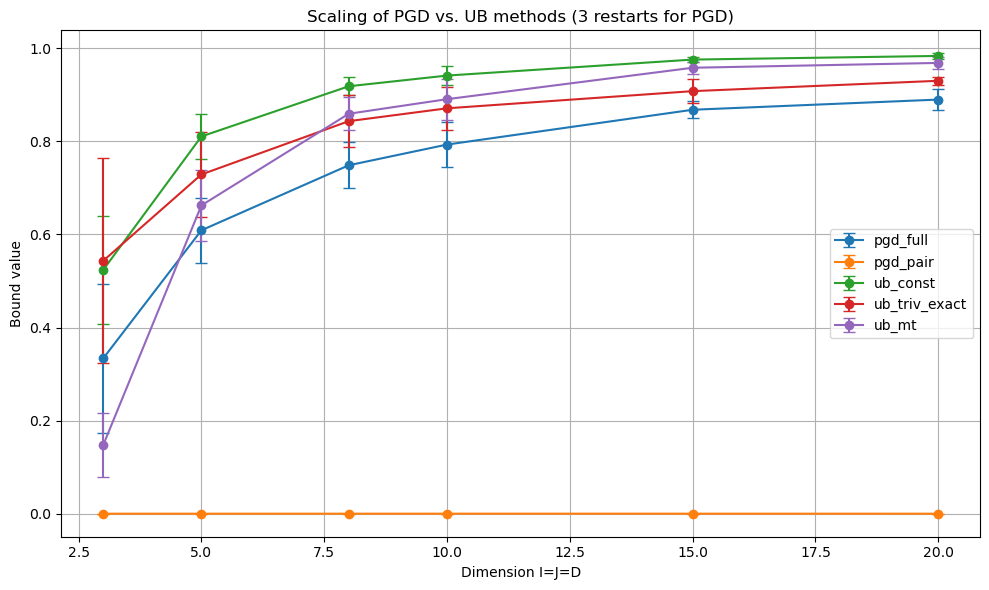

In [64]:
# ─── Define your customized run_all_bounds ───

def run_all_bounds(inst):
    return {
        'ub_const'     : constant_bound(inst),
        'ub_mt'        : multitangent_socp(inst,   K=7, solver="MOSEK"),
        'ub_triv_exact': trivial_spacing_exact(inst, grid=(-35.0,35.0,1e-3)),
        'pgd_pair'     : pgd_U_pair_corrected(
                             inst,
                             restarts=3,   # 3 random restarts
                             iters=250,    # 300 gradient steps
                             lr=0.04,      # learning rate
                          ),
        'pgd_full' : pgd_H_full_corrected(inst, restarts=3, iters = 250, lr=0.04)
    }

# ─── Grid‐search helper ───

def grid_search(I_values, seed_list, D_fn):
    records = []
    for I in I_values:
        for seed in seed_list:
            for D in D_fn(I):
                inst = default_instance(I=I, J=I, D=D, seed=seed)
                base = {'I': I, 'J': I, 'D': D, 'seed': seed}
                results = run_all_bounds(inst)
                records.append({**base, **results})
    return pd.DataFrame(records)

# ─── Sweep settings ───

I_vals = [3, 5, 8, 10, 15, 20]
seeds  = [0, 1, 2, 3]                # seed‐to‐seed variability
D_fn   = lambda I: [I]               # enforce D = I exactly

# ─── Run and collect ───

df = grid_search(I_vals, seeds, D_fn)

# ─── Collapse across seeds ───

methods = ['pgd_full', 'pgd_pair', 'ub_const', 'ub_triv_exact', 'ub_mt']
stats   = df.groupby('I')[methods].agg(['mean','std']).reset_index()

# ─── Plot mean ± σ ───

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for m in methods:
    means = stats[ (m, 'mean') ]
    errs  = stats[ (m, 'std')  ]
    plt.errorbar(
        stats['I'], means, yerr=errs,
        marker='o', capsize=4, label=m
    )

plt.xlabel('Dimension I=J=D')
plt.ylabel('Bound value')
plt.title('Scaling of PGD vs. UB methods (3 restarts for PGD)')
plt.legend()
plt.grid(True)
# plt.xscale('log'); plt.yscale('log')  # uncomment to check power‐laws
plt.tight_layout()
plt.show()


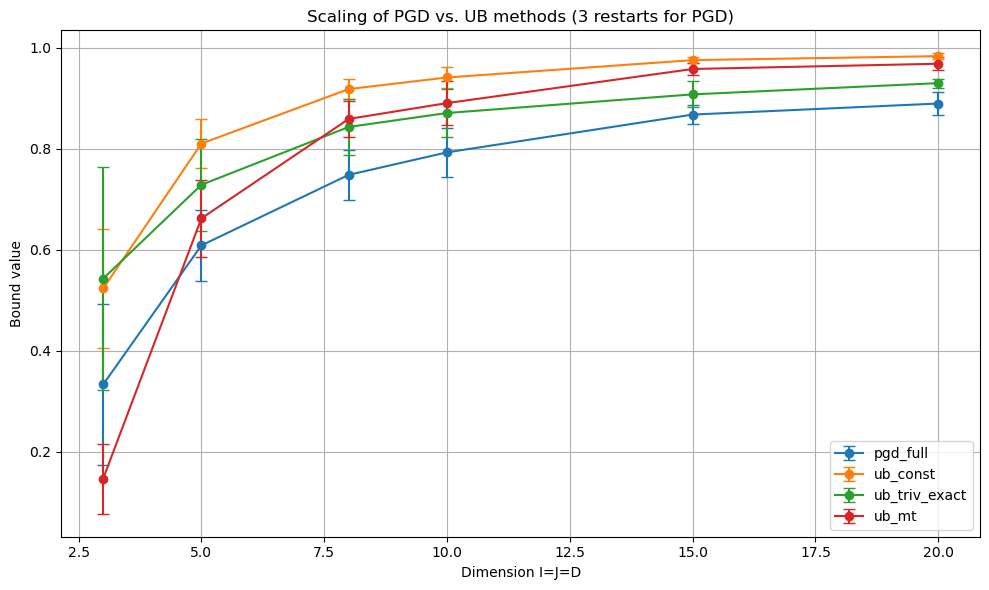

In [65]:
methods = ['pgd_full', 'ub_const', 'ub_triv_exact', 'ub_mt']
stats   = df.groupby('I')[methods].agg(['mean','std']).reset_index()

# ─── Plot mean ± σ ───

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for m in methods:
    means = stats[ (m, 'mean') ]
    errs  = stats[ (m, 'std')  ]
    plt.errorbar(
        stats['I'], means, yerr=errs,
        marker='o', capsize=4, label=m
    )

plt.xlabel('Dimension I=J=D')
plt.ylabel('Bound value')
plt.title('Scaling of PGD vs. UB methods (3 restarts for PGD)')
plt.legend()
plt.grid(True)
# plt.xscale('log'); plt.yscale('log')  # uncomment to check power‐laws
plt.tight_layout()
plt.show()

## UB Gram SOCP

In [71]:
def ub_gram_socp(inst, K=6, solver="MOSEK", verbose=False):
    """
    Gram–matrix SOCP upper bound on H_α(P,Q)  (sign-safe, no cancellations).
    Returns  √S★  – a certified UB on the hockey-stick divergence.
    """
    import math, numpy as np, cvxpy as cp

    # ───── 1. instance data ────────────────────────────────────────────
    I, J, D = int(inst["I"]), int(inst["J"]), int(inst["D"])
    eps     = float(inst["eps"])
    w, v    = np.asarray(inst["w"]), np.asarray(inst["v"])
    alpha   = math.exp(eps)

    c = np.concatenate(([w[0]-alpha*v[0]], w[1:], -alpha*v[1:]))  # len N
    N = 1+I+J
    t = 2.0*np.outer(c, c); np.fill_diagonal(t, 0.0)

    # ───── 2. envelopes κ(s)=e^{−s/4} on  ρ_k∈{0,2,…,2K} ──────────────
    rho_sq = (2*np.arange(K+1))**2
    U, L   = make_envelopes(rho_sq)        # lists (λ,μ)

    # ───── 3. variables ───────────────────────────────────────────────
    G = cp.Variable((N, N), PSD=True)
    z = cp.Variable((N, N), symmetric=True)

    cons = [z >= 0, z <= 1]                # κ is always in (0,1]

    # origin
    cons += [G[0, 0] == 0]
    for k in range(1, N):
        cons += [G[0, k] == 0, G[k, 0] == 0]

    # unit steps along each path
    for i in range(2, I+1):
        Dij = G[i, i] + G[i-1, i-1] - 2*G[i, i-1]
        cons += [Dij <= 1]
    for j in range(2, J+1):
        a, b = I+j-1, I+j
        Dij = G[a, a] + G[b, b] - 2*G[a, b]
        cons += [Dij <= 1]

    # cross constraints
    for i in range(1, I+1):
        ai = i
        for j in range(1, J+1):
            aj  = I + j
            Dij = G[ai, ai] + G[aj, aj] - 2*G[ai, aj]
            cons += [Dij <= max(i, j)**2]

    # envelopes:  every pair bounded by both L- and U-lines
    for a in range(N):
        for b in range(a+1, N):
            Dij = G[a, a] + G[b, b] - 2*G[a, b]
            for lam, mu in U:   cons += [z[a, b] <= lam*Dij + mu]
            for lam, mu in L:   cons += [z[a, b] >= lam*Dij + mu]

    # ───── 4. objective  (quadratic form) ─────────────────────────────
    obj  = 0.5 * cp.sum(cp.multiply(t, z))   # each pair twice
    prob = cp.Problem(cp.Maximize(obj), cons)
    prob.solve(solver=solver, verbose=verbose)

    S_star = max(prob.value, 0.0)            # guard round-off
    return math.sqrt(S_star)


In [72]:
inst = default_instance(I=10, J=10, D=10, eps=log(2), seed=0)
print("Gram-UB  :", ub_gram_socp(inst, K=6))

Gram-UB  : 0.0


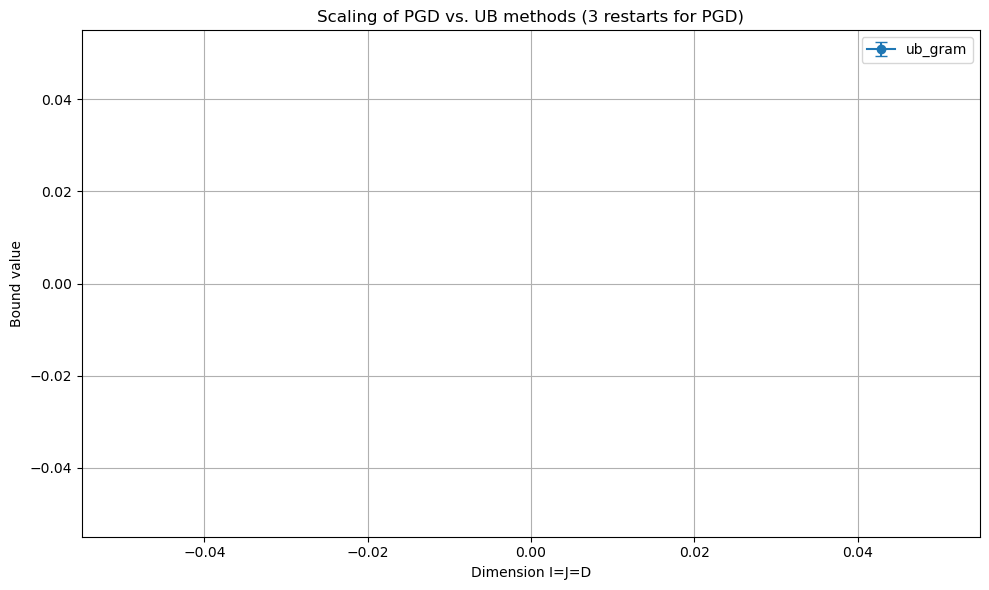

In [60]:
# ─── Define your customized run_all_bounds ───

def run_all_bounds(inst):
    return {
        'ub_gram'     : ub_gram_socp  (inst, K=6)
    }

# ─── Grid‐search helper ───

def grid_search(I_values, seed_list, D_fn):
    records = []
    for I in I_values:
        for seed in seed_list:
            for D in D_fn(I):
                inst = default_instance(I=I, J=I, D=D, seed=seed)
                base = {'I': I, 'J': I, 'D': D, 'seed': seed}
                results = run_all_bounds(inst)
                records.append({**base, **results})
    return pd.DataFrame(records)

# ─── Sweep settings ───

I_vals = [3, 5, 8, 10, 15, 20, 30]
seeds  = [0, 1, 2, 3]                # seed‐to‐seed variability
D_fn   = lambda I: [I]               # enforce D = I exactly

# ─── Run and collect ───

df = grid_search(I_vals, seeds, D_fn)

# ─── Collapse across seeds ───

methods = ['ub_gram']
stats   = df.groupby('I')[methods].agg(['mean','std']).reset_index()

# ─── Plot mean ± σ ───

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for m in methods:
    means = stats[ (m, 'mean') ]
    errs  = stats[ (m, 'std')  ]
    plt.errorbar(
        stats['I'], means, yerr=errs,
        marker='o', capsize=4, label=m
    )

plt.xlabel('Dimension I=J=D')
plt.ylabel('Bound value')
plt.title('Scaling of PGD vs. UB methods (3 restarts for PGD)')
plt.legend()
plt.grid(True)
# plt.xscale('log'); plt.yscale('log')  # uncomment to check power‐laws
plt.tight_layout()
plt.show()


In [61]:
df

,I,J,D,seed,ub_gram
0,3,3,3,0,inf
1,3,3,3,1,inf
2,3,3,3,2,inf
3,3,3,3,3,inf
4,5,5,5,0,inf
5,5,5,5,1,inf
6,5,5,5,2,inf
7,5,5,5,3,inf
8,8,8,8,0,inf
9,8,8,8,1,inf


## Testing PGD vs Collapsed Optimum

In [32]:
def collapsed_bound(inst):
    """
    Optimal value when μ is collapsed at 0 and ν is forced to take unit steps
    in some direction (any direction gives the same radii).
    """
    J, eps, v = inst["J"], inst["eps"], inst["v"]
    radii = np.arange(J + 1, dtype=float)        # 0,1,...,J
    return np.sum(v * g_eps(radii, eps))

In [43]:
# --------------------------------------------------------------------- #
#  Sanity-suite for the *pairwise* upper bound U
# --------------------------------------------------------------------- #
import numpy as np
import torch
import math

# ---- reusable helper: exact U(mu,nu) on *torch* tensors --------------
def U_pairwise_torch(mu: torch.Tensor,
                     nu: torch.Tensor,
                     w_np, v_np,
                     eps: float) -> float:
    """
    Computes  Σ_i Σ_j w_i v_j g_eps(||mu_i - nu_j||) exactly.
    Both mu and nu are torch tensors on the same device / dtype.
    """
    Dmat = torch.cdist(mu, nu)                         # (I+1, J+1)
    W = torch.as_tensor(w_np, dtype=mu.dtype, device=mu.device)
    V = torch.as_tensor(v_np, dtype=mu.dtype, device=mu.device)
    G = g_eps_torch(Dmat, eps)                         # same dtype/device
    return torch.sum(W[:, None] * V[None, :] * G).item()

# ------------------------------------------------------------------ #
def sanity_suite_square(dim_list=(10, 15, 20),
                        pgd_restarts=10, pgd_iters=800, pgd_seed=123,
                        coll_restarts=20, coll_iters=400,
                        verbose=True):
    """
    Runs   pgd_pair_full   (unconstrained)  and   pgd_pair_collapsed
    on square instances I=J=D for each D in dim_list.
    Prints a concise report and returns a list of dicts.
    """
    rows = []
    for D in dim_list:
        inst = default_instance(I=D, J=D, D=D, seed=pgd_seed)
        I, J, eps, w_np, v_np = inst["I"], inst["J"], inst["eps"], inst["w"], inst["v"]

        # ---------- 1) FULL pairwise PGD ----------
        val_est, mu_full, nu_full = pgd_pair_full(
            inst,
            restarts=pgd_restarts, iters=pgd_iters,
            lr=0.04, initial_scale=0.1,
            seed=pgd_seed, return_params=True
        )
        check_feasible(mu_full, nu_full)                     # raises if bad
        val_full = U_pairwise_torch(mu_full, nu_full, w_np, v_np, eps)

        # ---------- 2) ANALYTIC collapsed optimum ----------
        val_coll_analytic = collapsed_bound(inst)

        # ---------- store & optional print ----------
        rows.append(dict(
            D=D,
            full_estimate=val_est,
            full_exact=val_full,
            collapsed_exact=val_coll_analytic,
            gap=val_full - val_coll_analytic
        ))

        if verbose:
            print(f"\n===  I=J=D={D}  ===")
            print(f"  full-PGD (running)  : {val_est:.6f}")
            print(f"  full-PGD (exact U)  : {val_full:.6f}")
            print(f"  collapsed optimum   : {val_coll_analytic:.6f}")
            print(f"  gap (full − coll)   : {val_full-val_coll_analytic:+.6f}")

    return rows


In [44]:
results = sanity_suite_square()


===  I=J=D=10  ===
  full-PGD (running)  : 0.520459
  full-PGD (exact U)  : 0.520932
  collapsed optimum   : 0.782864
  gap (full − coll)   : -0.261932

===  I=J=D=15  ===
  full-PGD (running)  : 0.382248
  full-PGD (exact U)  : 0.382691
  collapsed optimum   : 0.818099
  gap (full − coll)   : -0.435408

===  I=J=D=20  ===
  full-PGD (running)  : 0.335710
  full-PGD (exact U)  : 0.336061
  collapsed optimum   : 0.922459
  gap (full − coll)   : -0.586398


In [6]:
g_eps(d=4, eps=2)

0.8873092332833976

## Sanity Check: Full H on Simple Arrangement

In [8]:
import numpy as np
import pandas as pd

# ---------- Monte-Carlo estimator ---------- #
def estimate_hockey_stick(D, v, eps=np.log(2.0), n_samples=100_000, rng=None):
    """
    Estimate the one-sided hockey-stick divergence H_α for the collapsed pair
      P(x) = N(0, I_D)                       (all μ_i = 0)
      Q(x) = Σ_{j=0}^D v_j N(x; (j,0,…,0), I_D)

    Arguments
    ---------
    D : int
        Dimension and number of mixture components (I = J = D).
    v : 1-D array-like, length D+1
        Mixture weights for Q, must sum to 1.
    eps : float
        Privacy parameter ε (α = e^ε).  Default ln 2  → α = 2.
    n_samples : int
        Number of Monte-Carlo draws.
    rng : np.random.Generator or None
        RNG to use (for reproducibility).

    Returns
    -------
    (estimate, stderr)
    """
    if rng is None:
        rng = np.random.default_rng()

    alpha = np.exp(eps)

    # Draw only the first coordinate — the rest integrate out.
    x1 = rng.normal(size=n_samples)

    j_vals = np.arange(D + 1)
    # N(x; (j,0,…), I_D) / N(x; 0, I_D)  depends only on x1 and j
    exp_terms = np.exp(np.outer(x1, j_vals) - 0.5 * j_vals**2)  # shape (N, D+1)

    r = exp_terms @ v                  # Q(x)/P(x) for each sample
    g = np.maximum(1.0 - alpha * r, 0) # integrand (P - αQ)_+
    est = g.mean()
    stderr = g.std(ddof=1) / np.sqrt(n_samples)

    return est, stderr


# ---------- Helper: random weights ---------- #
def random_simplex(k, rng):
    """k+1 random non-negative numbers summing to 1."""
    w = rng.uniform(size=k + 1)
    return w / w.sum()


# ---------- Experiments ---------- #
eps = np.log(2.0)                  # α = 2
n_samples = 100_000
rng = np.random.default_rng(123)

D_list = [2, 3, 5, 10]                 # feel free to add more
results = []

for D in D_list:
    # Uniform weights
    v_uni = np.ones(D + 1) / (D + 1)
    est, err = estimate_hockey_stick(D, v_uni, eps, n_samples, rng)
    results.append(dict(D=D, weights="uniform", estimate=est, stderr=err))

    # One random weight vector (seeded for reproducibility)
    rng_local = np.random.default_rng(D)   # separate seed per D
    v_rand = random_simplex(D, rng_local)
    est_r, err_r = estimate_hockey_stick(D, v_rand, eps, n_samples, rng)
    results.append(dict(D=D, weights=f"random_seed_{D}", estimate=est_r, stderr=err_r))

# ---------- Display ---------- #
df = pd.DataFrame(results)
pd.options.display.float_format = "{:,.6f}".format
display(df)


,D,weights,estimate,stderr
0,2,uniform,0.055562,0.000280
1,2,random_seed_2,0.225682,0.000695
2,3,uniform,0.163336,0.000531
3,3,random_seed_3,0.477984,0.001054
4,5,uniform,0.342462,0.000740
5,5,random_seed_5,0.119756,0.000436
6,10,uniform,0.573838,0.000797
7,10,random_seed_10,0.534796,0.000680
